# Example 1:

This example is based on the following paper:

A. Silva, D. Pizarro, and B. Stojadinovic, “Displacement prediction equations for seismic design of single
friction pendulum base-isolated structures”, In Press.

Goals of the example:

(1) Use the PCE_calculator$^{*1}$ module to calculate the cloud coefficients ($c_1$, $c_2$, $\beta_{GM}$) for a specific set of input parameters ($T_1 = 0.5s$, $m_1^* / m_{tot} = 0.8$, $\mu_f = 0.05$, and $T_b = 4s$).

(2) Compare the coefficients obtained with the linear regression model.

(3) Given the cloud parameters calculate the fragility curve$^{*2}$ for the limit state thresholds $D_{1,lim} = 0.05m$ and $u_{0,lim} = 0.2m$

$^{*1}:$ The explanation of how the PCE metamodels are calculated is available in the paper.

$^{*2}:$The relationship between the cloud coefficients and the fragility curve is available in the paper.

In [3]:
from PCE_calculator import InputChecker
from PCE_calculator import DataLoader
from PCE_calculator import PCECalculator

# Input
T1 = 0.5 # possible from 0.1 to 1
mratio = 0.8 # possible from 0.3 to 0.9
muf = 0.05 # possible from 0.03 to 0.18
Tb = 4 # possible from 3 to 6

# Type of Analysis
RQI = 'D1' # Response quantity of interest: possible entries 'D1' or 'u0'
IM = 'GM' # Intensity Measure: possible entries 'SC' for single component and 'GM' for geometric mean

# Calculate PCE
c1D1, c2D1, betaD1 = PCECalculator.run_PCE(T1,muf,mratio,Tb,RQI,IM)

# Type of Analysis
RQI = 'u0' # Response quantity of interest: possible entries 'D1' or 'u0'
IM = 'GM' # Intensity Measure: possible entries 'SC' for single component and 'GM' for geometric mean

# Calculate PCE
c1u0, c2u0, betau0 = PCECalculator.run_PCE(T1,muf,mratio,Tb,RQI,IM)

print(f'PCE coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= {c1D1:.3f}, c2= {c2D1:.3f}, beta = {betaD1:.3f} ')
print(f'PCE coefficients for u0 (for the Geometric Mean of PGV): c1= {c1u0:.3f}, c2= {c2u0:.3f}, beta = {betau0:.3f} ')

PCE coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= -3.595, c2= 0.357, beta = 0.245 
PCE coefficients for u0 (for the Geometric Mean of PGV): c1= -1.044, c2= 1.464, beta = 0.501 


In [4]:
import numpy as np
LRD1GM = np.array([[-0.1453, 1.586, 0.4747, -0.4994, -0.7003, 0],
                   [0.0784, 0.002268, 0.6157, 0.002314, 0.06066, 0.03760],
                   [-0.008072, -0.01091, 0.008155, 0.05067, 0.009336, 0.03706]])
LRu0GM = np.array([[-0.07942, -4.569, 1.199, -0.07217, 0.2391, 0.7472],
                   [1.438, 0.1767, 0.3891, 0.2714, -0.06987, 0],
                   [0.3892, 0.002644, 0.8942, 0.06850, 0.04740, 0.0702]])
c1D1_LR = LRD1GM[0,0] + LRD1GM[0,1] * np.log(T1) + LRD1GM[0,2] * np.log(muf) + LRD1GM[0,3] * np.log(mratio) + LRD1GM[0,4] * np.log(Tb)
c2D1_LR = LRD1GM[1,0] + LRD1GM[1,1] * (T1/Tb/muf)**2 + LRD1GM[1,2] /Tb + LRD1GM[1,3] / muf + LRD1GM[1,4] * T1 + LRD1GM[1,5] * mratio**2
betaD1_LR = LRD1GM[2,0] + LRD1GM[2,1] /muf + LRD1GM[2,2] * Tb + LRD1GM[2,3] /muf/Tb + LRD1GM[2,4] * mratio/muf + LRD1GM[2,5] / mratio

c1u0_LR = LRu0GM[0,0] + LRu0GM[0,1] * muf**0.5 + LRu0GM[0,2] * muf*T1 + LRu0GM[0,3] * T1 + LRu0GM[0,4] *Tb*muf + LRu0GM[0,5] * muf*mratio
c2u0_LR = LRu0GM[1,0] + LRu0GM[1,1] * muf*mratio/T1 + LRu0GM[1,2]*muf/mratio + LRu0GM[1,3]/Tb + LRu0GM[1,4]*mratio 
betau0_LR = LRu0GM[2,0] + LRu0GM[2,1]/muf + LRu0GM[2,2]*muf*mratio + LRu0GM[2,3]* T1**2 + LRu0GM[2,4] * muf*mratio/T1 + LRu0GM[2,5]*muf*Tb 
print(f'LR coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= {c1D1_LR:.3f}, c2= {c2D1_LR:.3f}, beta = {betaD1_LR:.3f} ')
print(f'LR coefficients for u0 (for the Geometric Mean of PGV): c1= {c1u0_LR:.3f}, c2= {c2u0_LR:.3f}, beta = {betau0_LR:.3f} ')

LR coefficients for D1 (for the Geometric Mean of Sd(T1)): c1= -3.526, c2= 0.347, beta = 0.255 
LR coefficients for u0 (for the Geometric Mean of PGV): c1= -1.029, c2= 1.488, beta = 0.513 


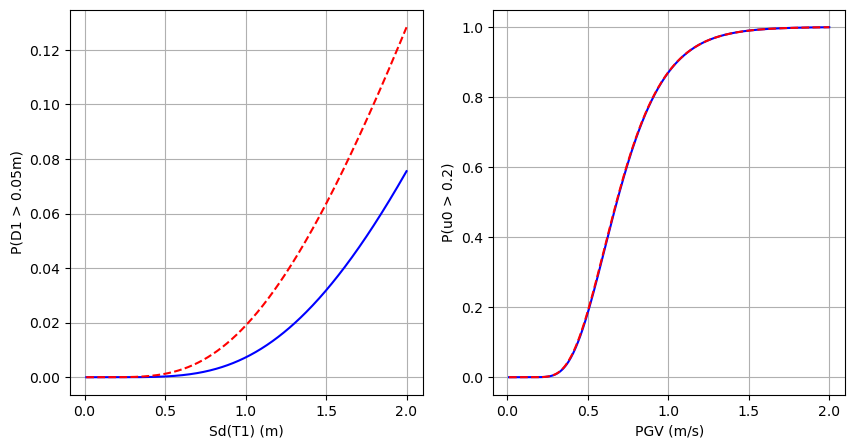

In [5]:
import numpy as np
from scipy.stats import norm
def frag_from_coefs(limit, IMs, c1, c2, beta):
    """
    Calculate the fragility function based on the cloud coefficients c1, c2 and beta.
    The fragility function is the probability of exceeding a "limit" given a "Sd".
    The formula of the cloud analysis is: ln(displacement) = c1 + c2 * ln(IM) + beta

    Args:
    - limit: limit threshold.
    - c1, c2, beta = cloud coefficients
    - IMs: Vector of intensity measure values (herein, Sd(T1) and PGV).

    Returns:
    - fragility: Vector of the fragility curve given IMs.
    """
    # Calculate the argument of the CDF
    argument = (np.log(limit) - (c1 + c2 * np.log(IMs))) / beta

    # Calculate the CDF using scipy.stats.norm.cdf
    fragility = 1 - norm.cdf(argument, 0, 1)

    return fragility

# Threshold limit for fragility function:
frag_limD1 = 0.05 # in meters
frag_limu0 = 0.2 # in meters

# Vector of IMs for the fragility function:
IMs = np.linspace(0.01, 2, num=400)
# Calculate fragility
fragilityD1 = frag_from_coefs(frag_limD1, IMs, c1D1, c2D1, betaD1)
fragilityu0 = frag_from_coefs(frag_limu0, IMs, c1u0, c2u0, betau0)

# Fragility with LR coefficients - less precise
fragilityD1_LR = frag_from_coefs(frag_limD1, IMs, c1D1_LR, c2D1_LR, betaD1_LR)
fragilityu0_LR = frag_from_coefs(frag_limu0, IMs, c1u0_LR, c2u0_LR, betau0_LR)

import matplotlib.pyplot as plt
fig, SubFig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
SubFig[0].plot(IMs, fragilityD1, color='b', linestyle='-')
SubFig[0].plot(IMs, fragilityD1_LR, color='r', linestyle='--')
SubFig[0].set_xlabel('Sd(T1) (m)')
SubFig[0].set_ylabel('P(D1 > 0.05m)')
SubFig[0].grid(True)

SubFig[1].plot(IMs, fragilityu0, color='b', linestyle='-')
SubFig[1].plot(IMs, fragilityu0_LR, color='r', linestyle='--')
SubFig[1].set_xlabel('PGV (m/s)')
SubFig[1].set_ylabel('P(u0 > 0.2)')
SubFig[1].grid(True)

Note that the fragility curve for D1 does not look very precise, but there is a "zoom" in the tail of the fragility curve. Moreover, Sd(T1 = 0.5s) = 1m is a very high seismic hazard. Consequently, when multiplied with a hazard curve (a very high hazard has a very low MAF), the difference in the resultant MAF becomes very low.